# CSC421 Assignment 1 Search, and CSP 

This assignment notebook explores topics covered in **Chapter 3 - Searching** and **Chapter 6 - Constraint Satisfaction Problems** from the book *Artificial Intelligence: A Modern Approach.* The code provided is based on parts of the aima-code repository but has been adapted, modified and simplified for the assignment. The notebook is self-contained and other than importing a few common packages you don't need to access any additional code. 

Plagiarism checking will be done. At the teaching team's discretion, a random subset of students may be examined in person and asked questions about the code submitted. Failure to understand the submitted code will result in a 0 grade for the entire assignment. 

The assignment structure is as follows: 

1. Search (Basic): Add a connection to the Romania map, try out search, print paths
2. Search (Basic): Return frontier lengths
3. Search (Expected): New Search
4. Search (Expected): Change the grid problem to 8 directions and finite square shape 
5. Search (Expected): Landgrid problem and Manhattan distance
6. CSP (Expected): CSP for a map of Australia with unitary constraint  
7. CSP (Advanced): Type inference toy example as CSP  

**IMPORTANT:** An assignment through Brightspace will provide the complete submission details. You will be required to submit this notebook. For working on the assignment, I recommend using the Jupyter-lab interface as it supports interactive development and is helpful for visualizations and plots. Please make sure the notebook you submit is clean, it should not be so heavily modified with debugging, additional figures, etc. that it becomes difficult to mark. Make sure that the notebook you submit is functioning and that you have used best practices in ensuring that (reloading the notebook, clearing history/memory, HINT: you may need to force refresh your browser (e.g., crtl+F5), ensuring that the submission is actually what you intend to submit for marking). We will **NOT** accept changes after the deadline if you have made a submission mistake.

In [1]:
## We'll start here defining useful imports, classes, and functions for later.
## Notably, we will create: 
### an abstract problem that allows us to define actions, actions costs, the results of a valid action and an ability to check if we have arrived at the goal
### a node for defining search tree expansion
### a priority queueu (useful for search algorithm implementations, as we discussed in the slides)
### a series of search algorithms under the umbrella of Best First Search, by choosing a particular cost function we can get form this a particular search algorithm!
#### *HINT* Examine these individual search algorithm implementations closely and try to understand how such small changes lead to completely different approaches


## ABSTRACT PROBLEM CLASS 
%matplotlib inline
import matplotlib.pyplot as plt
import random
import heapq
import math
import sys
import numpy as np
from collections import defaultdict, deque, Counter
from itertools import combinations

class Problem(object):
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default heuristic is 0 and the default action cost is 1 for all states.
    When you create an instance of a subclass, specify `initial`, and `goal` states 
    (or give an `is_goal` method) and perhaps other keyword args for the subclass."""

    def __init__(self, initial=None, goal=None, **kwds): 
        self.__dict__.update(initial=initial, goal=goal, **kwds) 
        
    def actions(self, state):        raise NotImplementedError
    def result(self, state, action): raise NotImplementedError
    def is_goal(self, state):        return state == self.goal
    def action_cost(self, s, a, s1): return 1
    def h(self, node):               return 0
    
    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)

class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)

    def __repr__(self): return '<{}>'.format(self.state)
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))
    def __lt__(self, other): return self.path_cost < other.path_cost
    
failure = Node('failure', path_cost=math.inf) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=math.inf) # Indicates iterative deepening search was cut off.
       
def expand(problem, node):
    "Expand a node, generating the children nodes."
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.action_cost(s, action, s1)
        yield Node(s1, node, action, cost)
        
def path_actions(node):
    "The sequence of actions to get to this node."
    if node.parent is None:
        return []  
    return path_actions(node.parent) + [node.action]

def path_states(node):
    "The sequence of states to get to this node."
    if node in (cutoff, failure, None): 
        return []
    return path_states(node.parent) + [node.state]

In [2]:
# PriorityQueue - note 
# there is a small difference from the 
# book implementation in order to ensure 
# sorting stability 

class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""

    def __init__(self, items=(), key=lambda x: x): 
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        self.item_count = 0 
        for item in items:
            self.add(item)
         
    def add(self, item):
        """Add item to the queuez."""
        pair = ((self.key(item),self.item_count), item)
        heapq.heappush(self.items, pair)
        self.item_count+=1  

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]
    
    def top(self): return self.items[0][1]

    def get_items(self): 
        return self.items.copy() 

    def __len__(self): return len(self.items)

In [3]:
# Different search algorithms 
# defined by appropriate definition of priorities 


def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    frontiers = [] 
    while frontier:
        frontier_items = frontier.get_items()
        frontiers.append(frontier_items)
        node = frontier.pop()
        
        if problem.is_goal(node.state):
            return (node,reached,frontiers)
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
        
    return (failure, reached, frontiers)

def g(n): return n.path_cost

def astar_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + h(n))
        
def greedy_bfs(problem, h=None):
    """Search nodes with minimum h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=h)

def uniform_cost_search(problem):
    "Search nodes with minimum path cost first."
    return best_first_search(problem, f=g)

def breadth_first_bfs(problem):
    "Search shallowest nodes in the search tree first; using best-first."
    return best_first_search(problem, f=len)


# QUESTION 1 Search (Basic) - 6 points

This question looks at how the RouteProblem works using the classic map of Romania. 

<img src="images/romania_map.png" width="45%">

1. Create a copy of the map of Romania specified below and call it romania_new
2. Add a connection from Fagaras to Vaslui with a cost of 345 in romania_new
3. Create a new RouteProblem called r_new using the **romania_new** map for the pair Arad (initial state) to Eforie (goal state)
4. Run **GreedySearch** search, print the solution path and path cost for r_new
5. Run **BreadthFirstSearch** search, print the solution path and path cost for r_new
6. Run **UniformCostSearch** search, print the solution path and path cost for r_new

*NOTE: an example of route problems, search calls, and printing is provided below*
*NOTE: node class has a cost already and you recieve the final node in the path from search functions which holds the total cost*

In [4]:
class RouteProblem(Problem):
    """A problem to find a route between locations on a `Map`.
    Create a problem with RouteProblem(start, goal, map=Map(...)}).
    States are the vertexes in the Map graph; actions are destination states."""
    
    def actions(self, state): 
        """The places neighboring `state`."""
        return self.map.neighbors[state]
    
    def result(self, state, action):
        """Go to the `action` place, if the map says that is possible."""
        return action if action in self.map.neighbors[state] else state
    
    def action_cost(self, s, action, s1):
        """The distance (cost) to go from s to s1."""
        return self.map.distances[s, s1]
    
    def h(self, node):
        "Straight-line distance between state and the goal."
        locs = self.map.locations
        return straight_line_distance(locs[node.state], locs[self.goal])
    
    
def straight_line_distance(A, B):
    "Straight-line distance between two points."
    return sum(abs(a - b)**2 for (a, b) in zip(A, B)) ** 0.5

In [5]:
class Map:
    """A map of places in a 2D world: a graph with vertexes and links between them. 
    In `Map(links, locations)`, `links` can be either [(v1, v2)...] pairs, 
    or a {(v1, v2): distance...} dict. Optional `locations` can be {v1: (x, y)} 
    If `directed=False` then for every (v1, v2) link, we add a (v2, v1) link."""

    def __init__(self, links, locations=None, directed=False):
        if not hasattr(links, 'items'): # Distances are 1 by default
            links = {link: 1 for link in links}
        if not directed:
            for (v1, v2) in list(links):
                links[v2, v1] = links[v1, v2]
        self.distances = links
        self.neighbors = multimap(links)
        self.locations = locations or defaultdict(lambda: (0, 0))

        
def multimap(pairs) -> dict:
    "Given (key, val) pairs, make a dict of {key: [val,...]}."
    result = defaultdict(list)
    for key, val in pairs:
        result[key].append(val)
    return result

In [6]:
# Some specific RouteProblems for you to examine, specifically using DIjkstra, Breadth First, and Greedy will generally give you very different results when expanding nodes that have many edges to explore

romania = Map(
    {('O', 'Z'):  71, ('O', 'S'): 151, ('A', 'Z'): 75, ('A', 'S'): 140, ('A', 'T'): 118, 
     ('L', 'T'): 111, ('L', 'M'):  70, ('D', 'M'): 75, ('C', 'D'): 120, ('C', 'R'): 146, 
     ('C', 'P'): 138, ('R', 'S'):  80, ('F', 'S'): 99, ('B', 'F'): 211, ('B', 'P'): 101, 
     ('B', 'G'):  90, ('B', 'U'):  85, ('H', 'U'): 98, ('E', 'H'):  86, ('U', 'V'): 142, 
     ('I', 'V'):  92, ('I', 'N'):  87, ('P', 'R'): 97},
    {'A': ( 76, 497), 'B': (400, 327), 'C': (246, 285), 'D': (160, 296), 'E': (558, 294), 
     'F': (285, 460), 'G': (368, 257), 'H': (548, 355), 'I': (488, 535), 'L': (162, 379),
     'M': (160, 343), 'N': (407, 561), 'O': (117, 580), 'P': (311, 372), 'R': (227, 412),
     'S': (187, 463), 'T': ( 83, 414), 'U': (471, 363), 'V': (535, 473), 'Z': (92, 539)})


romania_r0 = RouteProblem('A', 'A', map=romania)
romania_r1 = RouteProblem('A', 'B', map=romania)
romania_r2 = RouteProblem('N', 'L', map=romania)
romania_r3 = RouteProblem('E', 'T', map=romania)
romania_r4 = RouteProblem('O', 'M', map=romania)

print("Greedy Search Examples")
greedy_s0, reached, frontiers = greedy_bfs(romania_r0)
greedy_s1, reached, frontiers = greedy_bfs(romania_r1)
greedy_s2, reached, frontiers = greedy_bfs(romania_r2)
greedy_s3, reached, frontiers = greedy_bfs(romania_r3)
greedy_s4, reached, frontiers = greedy_bfs(romania_r4)
print(path_states(greedy_s0))
print(path_states(greedy_s1))
print(path_states(greedy_s2))
print(path_states(greedy_s3))
print(path_states(greedy_s4))

print("Breadth First Search Examples")
bfs_s0, reached, frontiers = breadth_first_bfs(romania_r0)
bfs_s1, reached, frontiers = breadth_first_bfs(romania_r1)
bfs_s2, reached, frontiers = breadth_first_bfs(romania_r2)
bfs_s3, reached, frontiers = breadth_first_bfs(romania_r3)
bfs_s4, reached, frontiers = breadth_first_bfs(romania_r4)
print(path_states(bfs_s0))
print(path_states(bfs_s1))
print(path_states(bfs_s2))
print(path_states(bfs_s3))
print(path_states(bfs_s4))

print("Uniform Cost Search Examples")
uniform_s0, reached, frontiers = uniform_cost_search(romania_r0)
uniform_s1, reached, frontiers = uniform_cost_search(romania_r1)
uniform_s2, reached, frontiers = uniform_cost_search(romania_r2)
uniform_s3, reached, frontiers = uniform_cost_search(romania_r3)
uniform_s4, reached, frontiers = uniform_cost_search(romania_r4)
print(path_states(uniform_s0))
print(path_states(uniform_s1))
print(path_states(uniform_s2))
print(path_states(uniform_s3))
print(path_states(uniform_s4))

# the answer should be 
# Greedy Search Examples
# ['A']
# ['A', 'S', 'F', 'B']
# ['N', 'I', 'V', 'U', 'B', 'F', 'S', 'R', 'C', 'D', 'M', 'L']
# ['E', 'H', 'U', 'B', 'F', 'S', 'A', 'T']
# ['O', 'S', 'R', 'C', 'D', 'M']
# Breadth First Search Examples
# ['A']
# ['A', 'S', 'F', 'B']
# ['N', 'I', 'V', 'U', 'B', 'F', 'S', 'A', 'T', 'L']
# ['E', 'H', 'U', 'B', 'F', 'S', 'A', 'T']
# ['O', 'Z', 'A', 'T', 'L', 'M']
# Uniform Cost Search Examples
# ['A']
# ['A', 'S', 'R', 'P', 'B']
# ['N', 'I', 'V', 'U', 'B', 'P', 'C', 'D', 'M', 'L']
# ['E', 'H', 'U', 'B', 'P', 'R', 'S', 'A', 'T']
# ['O', 'Z', 'A', 'T', 'L', 'M']

Greedy Search Examples
['A']
['A', 'S', 'F', 'B']
['N', 'I', 'V', 'U', 'B', 'F', 'S', 'R', 'C', 'D', 'M', 'L']
['E', 'H', 'U', 'B', 'F', 'S', 'A', 'T']
['O', 'S', 'R', 'C', 'D', 'M']
Breadth First Search Examples
['A']
['A', 'S', 'F', 'B']
['N', 'I', 'V', 'U', 'B', 'F', 'S', 'A', 'T', 'L']
['E', 'H', 'U', 'B', 'F', 'S', 'A', 'T']
['O', 'Z', 'A', 'T', 'L', 'M']
Uniform Cost Search Examples
['A']
['A', 'S', 'R', 'P', 'B']
['N', 'I', 'V', 'U', 'B', 'P', 'C', 'D', 'M', 'L']
['E', 'H', 'U', 'B', 'P', 'R', 'S', 'A', 'T']
['O', 'Z', 'A', 'T', 'L', 'M']


In [7]:
# Your Q1 ANSWER GOES HERE  

# Part 1 and 2 ANSWER
romania_new = Map(
    {('O', 'Z'):  71, ('O', 'S'): 151, ('A', 'Z'): 75, ('A', 'S'): 140, ('A', 'T'): 118, 
     ('L', 'T'): 111, ('L', 'M'):  70, ('D', 'M'): 75, ('C', 'D'): 120, ('C', 'R'): 146, 
     ('C', 'P'): 138, ('R', 'S'):  80, ('F', 'S'): 99, ('B', 'F'): 211, ('B', 'P'): 101, 
     ('B', 'G'):  90, ('B', 'U'):  85, ('H', 'U'): 98, ('E', 'H'):  86, ('U', 'V'): 142, 
     ('I', 'V'):  92, ('I', 'N'):  87, ('P', 'R'): 97, ('F', 'V'): 345},
    {'A': ( 76, 497), 'B': (400, 327), 'C': (246, 285), 'D': (160, 296), 'E': (558, 294), 
     'F': (285, 460), 'G': (368, 257), 'H': (548, 355), 'I': (488, 535), 'L': (162, 379),
     'M': (160, 343), 'N': (407, 561), 'O': (117, 580), 'P': (311, 372), 'R': (227, 412),
     'S': (187, 463), 'T': ( 83, 414), 'U': (471, 363), 'V': (535, 473), 'Z': (92, 539)})
# Part 3 ANSWER
r_new = RouteProblem('A', 'E', map=romania_new )
# Part 4 ANSWER
greedy_sNew, reached, frontiers = greedy_bfs(r_new)
print("Greedy Search path: ")
print(path_states(greedy_sNew))
print("Final cost: {}".format(greedy_sNew.path_cost))

# Part 5 ANSWER
bfs_sNew, reached, frontiers = breadth_first_bfs(r_new)
print("\nBreadth First Search path: ")
print(path_states(bfs_sNew))
print("Final cost: {}".format(bfs_sNew.path_cost))
# Part 6 ANSWER
uniform_sNew, reached, frontiers = uniform_cost_search(r_new)
print("\nUniform Search path: ")
print(path_states(uniform_sNew))
print("Final cost: {}".format(uniform_sNew.path_cost))

Greedy Search path: 
['A', 'S', 'F', 'B', 'U', 'H', 'E']
Final cost: 719

Breadth First Search path: 
['A', 'S', 'F', 'V', 'U', 'H', 'E']
Final cost: 910

Uniform Search path: 
['A', 'S', 'R', 'P', 'B', 'U', 'H', 'E']
Final cost: 687


# QUESTION 2 Search (Basic) - 4 points
Here we dig deeper on the search process and compare uniform vs A* search frontiers.
1. Implement the function frontier_lengths. This function should return a list with the lengths of the frontier during the operation of the search algorithm given the frontier list.
2. Define a new route problem called route_l_f_new using romania_new going from  Lugoj (initial state) to  Fagaras (goal state).
3. Now run this function on the output of **UniformCostSearch** for problem route_l_f_new above AND print the object returned (see example below).
4. Now run this function on the output of **AStarSearch** for problem route_l_f_new AND print the object returned (see example below).

In [8]:
# Your Q2 PART 1 ANSWER GOES HERE
# Part 1 ANSWER
def frontier_lengths(frontiers):
    frontier_list = []
    
    for lengths in frontiers:
        i = 0
        for x in lengths:
            i += 1
        frontier_list.append(i)
    
    return(frontier_list)

# An example to illustrate functionality and printing output on the Arad to Bucharest route
s1, reached, frontiers = uniform_cost_search(romania_r1)
# This will not work until you implement frontier_lengths above
print(frontier_lengths(frontiers))

# the answer should be 
# [1, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 3, 2]

[1, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 3, 2]


In [9]:
# Q2 PART 2 ANSWER GOES HERE

# Part 2 ANSWER
route_l_f_new = RouteProblem('L', 'F', map=romania_new)

In [10]:
# Q2 PART 3 ANSWER GOES HERE

# Part 3 ANSWER
s2, reached, frontiers = uniform_cost_search(route_l_f_new)
print(frontier_lengths(frontiers))

[1, 2, 2, 2, 2, 3, 4, 4, 4, 3, 3, 2]


In [11]:
# Q2 PART 4 ANSWER GOES HERE

# Part 4 ANSWER
s3, reached, frontiers = astar_search(route_l_f_new)
print(frontier_lengths(frontiers))

[1, 2, 2, 2, 2, 3, 4, 5]


# QUESTION 3 New Search (Expected) - 6 points

Static weighted A* star is a way to tradeoff optimality for speed. Here you will implement a static weighting of the heuristic in a new A* function. In this search algorithm, the node selected for expansion is biased toward the heuruistic when the weight $\omega>1$. *NOTE: Dynamic weighted A\* also exists, where $\omega$ adjusts with respect to some factor, such as how close we are to the goal.*

The formula for the cost funtion for static weighted astar is $f(n) = g(n) + \omega h(n)$

1. Write your own search algorithm called **static_weighted_astar_search**.  Do not modify *best_first_search*, but rather, call it and assign priorities appropritetly to each node, see the example search algorithms given to you above. **static_weighted_astar_search** should accept the route problem and the weight value $\omega$
2. Print the path, path cost, and frontier lengths for **UniformSearch** on route_l_f_new problem.
3. Print the path, path cost, and frontier lengths for **AStarSearch** on route_l_f_new problem.
4. Use the new static_weighted_astar_search algorithm on route_l_f_new with $\omega=1.0$.
   Print the path, path cost, and frontier lengths for **static_weighted_astar_search** on route_l_f_new problem.
5. Use the new static_weighted_astar_search algorithm on route_l_f_new with $\omega=10.0$.
   Print the path, path cost, and frontier lengths for **static_weighted_astar_search** on route_l_f_new problem.
6. Use the new static_weighted_astar_search algorithm on route_l_f_new with $\omega=100.0$.
   Print the path, path cost, and frontier lengths for **static_weighted_astar_search** on route_l_f_new problem.


In [12]:
# Q3  Part 1 ANSWER GOES HERE
def static_weighted_astar_search(problem, w, h=None):
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + w*h(n)) 

In [13]:
# Q3  Part 2-6 ANSWER GOES HERE
uniform_rlfw, reached, frontiers = uniform_cost_search(route_l_f_new)
print("Uniform Search path: ")
print(path_states(uniform_rlfw))

astar_rlfw, reached, frontiers = astar_search(route_l_f_new)
print("\nAstar Search path: ")
print(path_states(astar_rlfw))

static_rlfw, reached, frontiers = static_weighted_astar_search(route_l_f_new, 1.0)
print("\nStatic Weighted Astar Search path: ")
print(path_states(static_rlfw))
print("\nFinal cost: {}".format(static_rlfw.path_cost))
print("Frontier length: {}".format(frontier_lengths(frontiers)))

static2_rlfw, reached, frontiers = static_weighted_astar_search(route_l_f_new, 10.0)
print("\nStatic Weighted Astar Search path: ")
print(path_states(static2_rlfw))
print("Final cost: {}".format(static2_rlfw.path_cost))
print("Frontier length: {}".format(frontier_lengths(frontiers)))

static3_rlfw, reached, frontiers = static_weighted_astar_search(route_l_f_new, 100.0)
print("\nStatic Weighted Astar Search path: ")
print(path_states(static3_rlfw))
print("Final cost: {}".format(static3_rlfw.path_cost))
print("Frontier length: {}".format(frontier_lengths(frontiers)))

Uniform Search path: 
['L', 'T', 'A', 'S', 'F']

Astar Search path: 
['L', 'T', 'A', 'S', 'F']

Static Weighted Astar Search path: 
['L', 'T', 'A', 'S', 'F']

Final cost: 468
Frontier length: [1, 2, 2, 2, 2, 3, 4, 5]

Static Weighted Astar Search path: 
['L', 'M', 'D', 'C', 'R', 'S', 'F']
Final cost: 590
Frontier length: [1, 2, 2, 2, 2, 3, 3, 3, 4]

Static Weighted Astar Search path: 
['L', 'M', 'D', 'C', 'R', 'S', 'F']
Final cost: 590
Frontier length: [1, 2, 2, 2, 3, 3, 3, 5]


# QUESTION 4 Search (Expected) - 5 points

1. Create a new class of search problems called **GridProblemMod** by copying and renaming the **GridProblem** class below appropriately.
2. For **GridProblemMod** extend the directions the agent can move to so that diagonal movement is allowed i.e. up-left/up/up-right/left/right/down-left/down/down-right movement using that order.
3. Unlike the original **GridProblem**, in this case, the grid will be finite and square. Add a parameter to the __init__ method called size that determines the size $N$ of the land grid which is a $N$ by $N$ square. Note this impacts a particular function you now need to modify for this to gracefully stay inside the square.

In [14]:
def straight_line_distance(A, B):
    "Straight-line distance between two points."
    return sum(abs(a - b)**2 for (a, b) in zip(A, B)) ** 0.5

def transpose(matrix): return list(zip(*matrix))


### Starting point for GridProblemMod
class GridProblem(Problem):
    """Finding a path on a 2D grid with obstacles. Obstacles are (x, y) cells."""

    def __init__(self, initial=(15, 30), goal=(130, 30), obstacles=(), **kwds):
        Problem.__init__(self, initial=initial, goal=goal, 
                         obstacles=set(obstacles) - {initial, goal}, **kwds)

    directions = [(-1, 0), (0, 1), (1,  0), (0,-1)]
    
    def action_cost(self, s, action, s1): return straight_line_distance(s, s1)
    
    def h(self, node): return straight_line_distance(node.state, self.goal)
                  
    def result(self, state, action): 
        "Both states and actions are represented by (x, y) pairs."
        return action if action not in self.obstacles else state
    
    def actions(self, state):
        """You can move one cell in any of `directions` to a non-obstacle cell."""
        x, y = state
        return {(x + dx, y + dy) for (dx, dy) in self.directions} - self.obstacles
        

### Simple Grid problem plotting
def plot_simple_grid_problem(grid, solution, reached=(), title='Search', show=True):
    "Use matplotlib to plot the grid, obstacles, solution, and reached."
    grid_board = []
    for i in range(0,grid.size): 
        for j in range(0,grid.size): 
            grid_board.append((i,j))
            
    nlocations =  grid.size
    
    plt.figure(figsize=(5, 5))
    plt.axis('on'); 
    plt.xlim((-0.5,nlocations-0.5))
    plt.ylim((-0.5,nlocations-0.5))
    plt.scatter(*transpose(grid_board), (250 / nlocations) **2, marker='s', c='lightgrey')
    if (grid.obstacles): 
        plt.scatter(*transpose(grid.obstacles), (250 / nlocations) **2, marker='s', c='black')
    plt.scatter(*transpose(reached), (50/nlocations)**2, marker='o', c='blue')
    plt.scatter(*transpose(path_states(solution)), (100 / nlocations) **2,marker='s', c='red')
    plt.scatter(*transpose([grid.initial]), (50/nlocations)**2, marker='D', c='white')
    plt.scatter(*transpose([grid.goal]), (125/nlocations)**2, marker='*', c='white')
    if show: plt.show()
    print('{} {} search: {:.1f} path cost, {:,d} states reached'
          .format(' ' * 10, title, solution.path_cost, len(reached)))

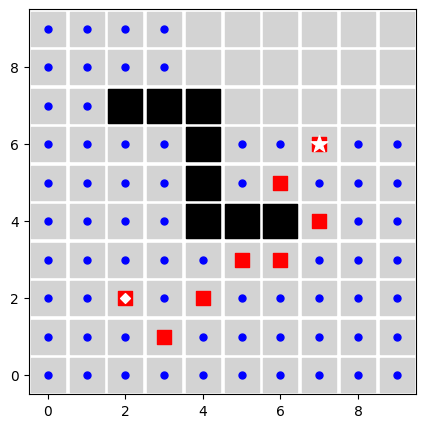

           G1 BFS search: 9.5 path cost, 75 states reached


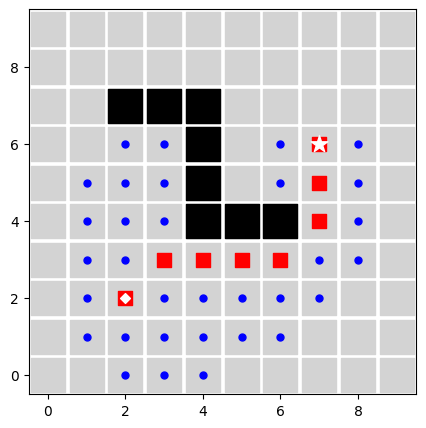

           G1 A* search: 7.8 path cost, 40 states reached


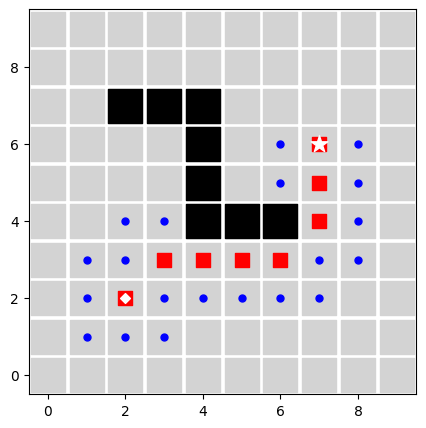

           G1 Static Wieghted A* search: 7.8 path cost, 28 states reached


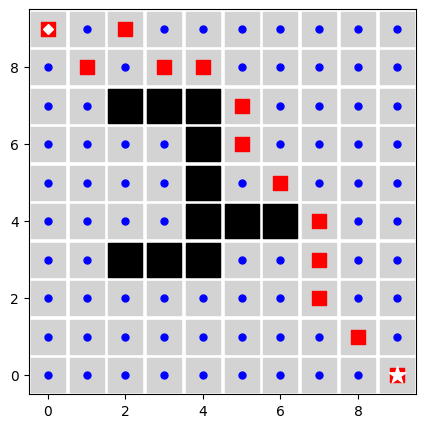

           G1 BFS search: 15.3 path cost, 89 states reached


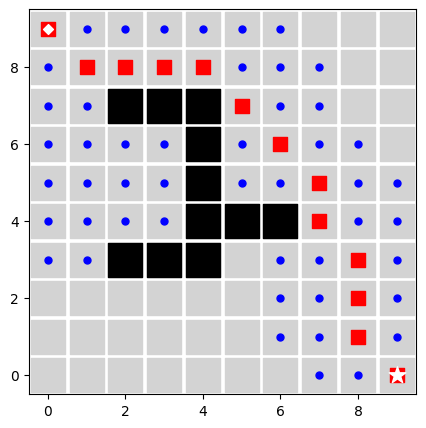

           G1 A* search: 14.5 path cost, 61 states reached


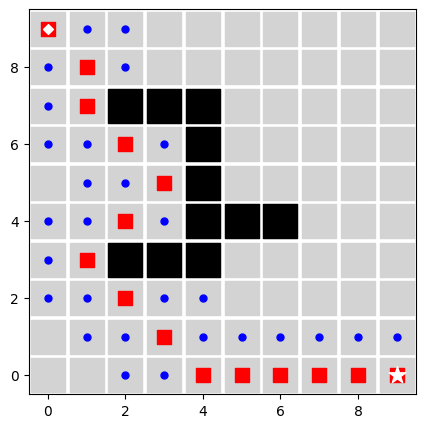

           G1 Static Wieghted A* search: 17.3 path cost, 43 states reached


In [15]:
# question 4 ANSWER GOES HERE 
# add your GridProblemMod class 
# and then check that the code provided works 
# and produces the desired output 
# you can add some check of your own to 
# see how things work 
class GridProblemMod(Problem):
    """Finding a path on a 2D grid with obstacles. Obstacles are (x, y) cells."""

    def __init__(self, initial=(15, 30), goal=(130, 30), size=(), obstacles=(), **kwds):
        Problem.__init__(self, initial=initial, goal=goal, 
                         obstacles=set(obstacles) - {initial, goal}, size=size, **kwds)

    directions = [(-1, 1), (0, 1), (1, 1), (-1, 0), (1,  0), (-1,-1), (0,-1), (1,-1)]
    
    def action_cost(self, s, action, s1): return straight_line_distance(s, s1)
    
    def h(self, node): return straight_line_distance(node.state, self.goal)
                  
    def result(self, state, action): 
        "Both states and actions are represented by (x, y) pairs."
        return action if action not in self.obstacles else state
    
    def actions(self, state):
        """You can move one cell in any of `directions` to a non-obstacle cell."""
        x, y = state
        return {(x + dx, y + dy) for (dx, dy) in self.directions if 0 <= (x + dx) <= self.size-1 and 0 <= (y + dy) <= self.size-1} - self.obstacles


# This code will not work until you implement all Parts above
gmod1 = GridProblemMod(initial = (2,2), goal = (7,6), size=10, obstacles = [(4,4),(5,4),(6,4),(4,5),(4,6),(4,7),(3,7),(2,7)])

(bfs_g1, bfsreached1, bfsfrontiers1) = breadth_first_bfs(gmod1)
plot_simple_grid_problem(gmod1, bfs_g1, bfsreached1, title='G1 BFS', show=True)

(astar_g1, reached1b, frontiers1b) = astar_search(gmod1)
plot_simple_grid_problem(gmod1, astar_g1, reached1b, title='G1 A*', show=True)

(stastar_g1, stareached1b, stafrontiers1b) = static_weighted_astar_search(gmod1, 100.0)
plot_simple_grid_problem(gmod1, stastar_g1, stareached1b, title='G1 Static Wieghted A*', show=True)


gmod2 = GridProblemMod(initial = (0,9), goal = (9,0), size=10, obstacles = [(4,4),(5,4),(6,4),(4,5),(4,6),(4,7),(3,7),(2,7),(4,3),(3,3),(2,3)])

(bfs_g2, bfsreached2, bfsfrontiers2) = breadth_first_bfs(gmod2)
plot_simple_grid_problem(gmod2, bfs_g2, bfsreached2, title='G1 BFS', show=True)

(astar_g2, astarreached2b, frontiers2b) = astar_search(gmod2)
plot_simple_grid_problem(gmod2, astar_g2, astarreached2b, title='G1 A*', show=True)

(stastar_g2, stareached2b, stafrontiers2b) = static_weighted_astar_search(gmod2, 100.0)
plot_simple_grid_problem(gmod2, stastar_g2, stareached2b, title='G1 Static Wieghted A*', show=True)

# QUESTION 5 Search (Expected) - 4 points

1. Create a new class of search problems called **LandgridProblem** by copying and renaming the **GridProblemMod** class you completed in the previous question.
2. Each location on the LandGrid has an associated number representing the "cost" of going through that location. Grass corresponds to 1, hills correspond to 2, and mountains correspond to 3. This is similar to tile-based board games such as Settlers of Catan or computer games such as Civilization.
3. You will need to modify the action_cost method to take into account the land cost. So if a path contains two grass squares, three hills, and one mountain the total path cost will be $2 * 1 + 3 * 2 + 1 * 3 = 11$. 
4. Add a **Manhattan distance** heuristic to your implementation. The **Manhattan distance** between two points $(x_1, y_1)$ and $(x_2, y_2)$ is defined as $|x_2 - x_1| + |y_2 - y_1|$. The choice of heuristic should be specified by an argument to the LandGridProblem, how this is done can be seen in the init function provided below. See the tests below where we use A* and greedy to trigger the use of the heuristics!

For example: 
```
d4_h1 = LandgridProblem(initial = (2,2), goal=(7,6), land_grid = land_grid4, heuristic='straight')
d4_h2 = LandgridProblem(initial = (2,2), goal=(7,6), land_grid = land_grid4, heuristic='manhattan')
```

Some code for creating, printing, and plotting land grids is provided below. 

**IMPORTANT:**
Here is the __init__ function you will need to use. 

```
def __init__(self, initial=(2, 2), goal=(4, 4), land_grid=[],heuristic="straight",**kwds):
        size = len(land_grid)
        self.size = size 
        self.heuristic = heuristic 
        Problem.__init__(self, initial=initial, goal=goal, land_grid = land_grid, size = size, heuristic=heuristic, **kwds)
```

In [16]:
land_grid1 = [[1,1,2,3,3],[1,2,1,3,1],[1,1,3,1,1],[2,2,2,3,3],[3,1,1,1,1]]
land_grid2 = [[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]]

def create_random_land_grid(n): 
    matrix = [] 
    random.seed(30)
    for i in range(0,n): 
        row = [] 
        for i in range(0,n): 
            row.append(random.randint(1, 3))
        matrix.append(row)
    return matrix 

land_grid4 = create_random_land_grid(15)


In [17]:
# QUESTION 5 ANSWER GOES HERE 

class LandgridProblem(Problem):

    def __init__(self, initial=(2, 2), goal=(4, 4), land_grid=[],heuristic="straight",**kwds):
        size = len(land_grid)
        self.size = size 
        self.heuristic = heuristic 
        Problem.__init__(self, initial=initial, goal=goal, land_grid = land_grid, size = size, heuristic=heuristic, **kwds)

    directions = [(-1, 1), (0, 1), (1, 1), (-1, 0), (1,  0), (-1,-1), (0,-1), (1,-1)]
    
    def action_cost(self, s, action, s1):
        x, y = s1
        return self.land_grid[x][y]
    
    def h(self, node): 
        if self.heuristic == "manhattan":
            manh_result = abs(self.goal[0] - node.state[0]) + abs(self.goal[1] - node.state[1])
            return manh_result
        if self.heuristic == "straight":
            return straight_line_distance(node.state, self.goal)
                  
    def result(self, state, action): 
        "Both states and actions are represented by (x, y) pairs."
        return action
    
    def actions(self, state):
        """You can move one cell in any of `directions` to a non-obstacle cell."""
        x, y = state
        return {(x + dx, y + dy) for (dx, dy) in self.directions if 0 <= (x + dx) <= self.size-1 and 0 <= (y + dy) <= self.size-1}

In [18]:
def plot_grid_problem(grid, solution, reached=(), title='Search', show=True):
    "Use matplotlib to plot the grid, obstacles, solution, and reached."
    grass_points = [] 
    hill_points = [] 
    mountain_points = [] 
    for i in range(0,grid.size): 
        for j in range(0,grid.size): 
            if (grid.land_grid[i][j] == 1): 
                grass_points.append((i,j))
            elif (grid.land_grid[i][j] == 2): 
                hill_points.append((i,j))
            elif (grid.land_grid[i][j] == 3): 
                mountain_points.append((i,j))
    
    nlocations =  grid.size
    plt.figure(figsize=(5, 5))
    plt.axis('on'); 
    plt.xlim((-0.5,nlocations-0.5))
    plt.ylim((-0.5,nlocations-0.5))
    if (grass_points):
        plt.scatter(*transpose(grass_points), (250 / nlocations) **2, marker='s', c='green')
    if (hill_points): 
        plt.scatter(*transpose(hill_points), (250 / nlocations) **2, marker='s', c='yellow')
    if (mountain_points): 
        plt.scatter(*transpose(mountain_points), (250 / nlocations) **2, marker='s', c='black')
    plt.scatter(*transpose(reached), (50/nlocations)**2, marker='o', c='blue')
    plt.scatter(*transpose(path_states(solution)), (100 / nlocations) **2,marker='s', c='red')
    plt.scatter(*transpose([grid.initial]), (50/nlocations)**2, marker='D', c='white')
    plt.scatter(*transpose([grid.goal]), (125/nlocations)**2, marker='*', c='lightgreen')
    if show: plt.show()
    print('{} {} search: {:.1f} path cost, {:,d} states reached'
          .format(' ' * 10, title, solution.path_cost, len(reached)))

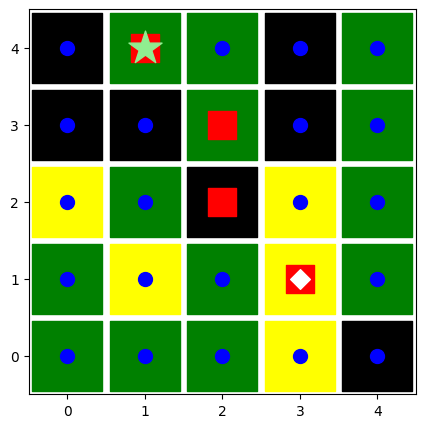

           D1 BFS search: 5.0 path cost, 25 states reached


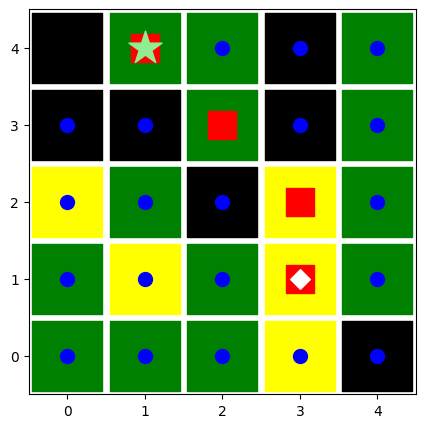

           D1 UCF search: 4.0 path cost, 24 states reached


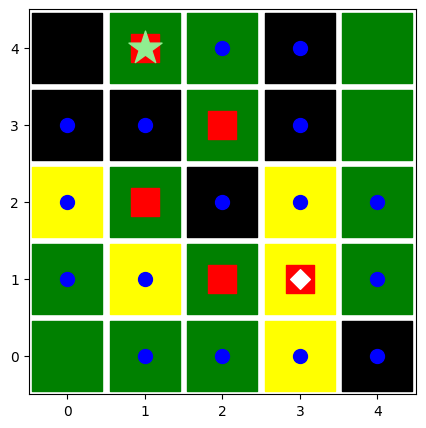

           D1 A* search search: 4.0 path cost, 21 states reached


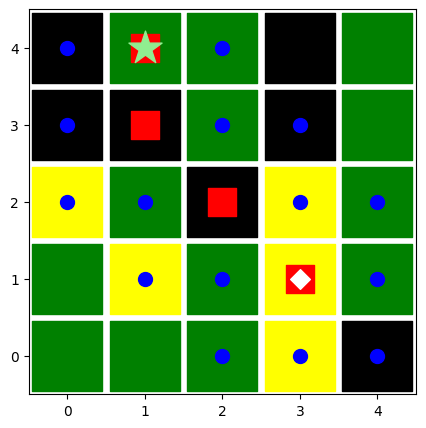

           D1 Greedy search: 7.0 path cost, 19 states reached


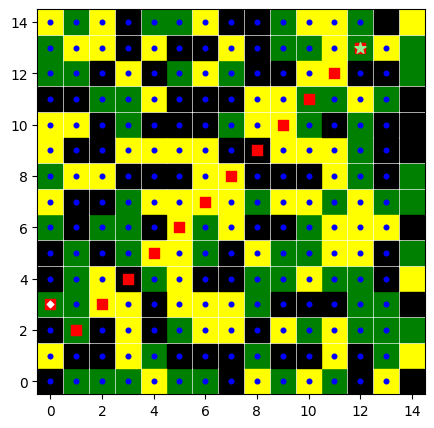

           D4 BFS search: 23.0 path cost, 209 states reached


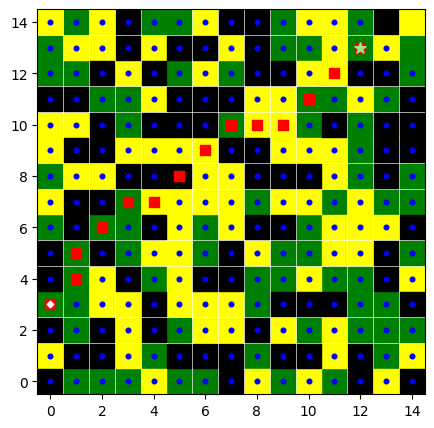

           D4 UCF search: 20.0 path cost, 222 states reached


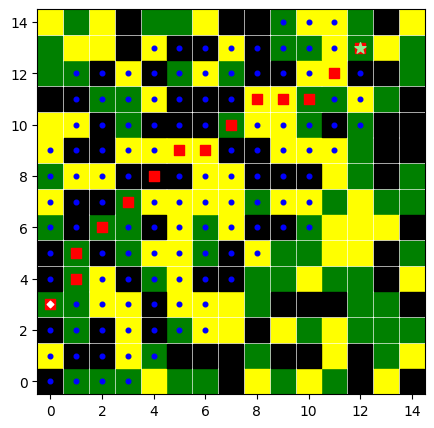

           D4 A* search: 20.0 path cost, 133 states reached


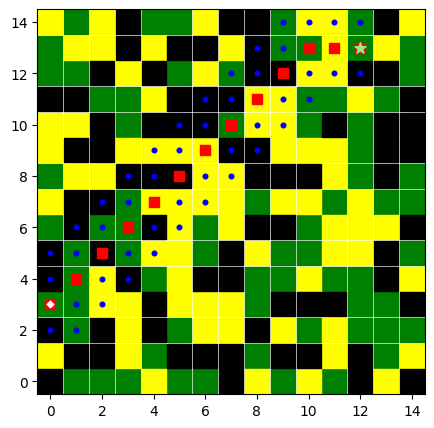

           D4 Greedy search: 22.0 path cost, 59 states reached


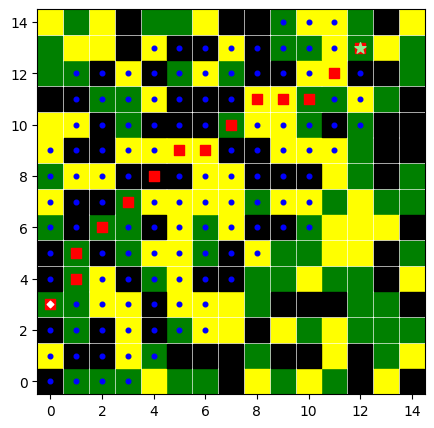

           D4 A* Straight search: 20.0 path cost, 133 states reached


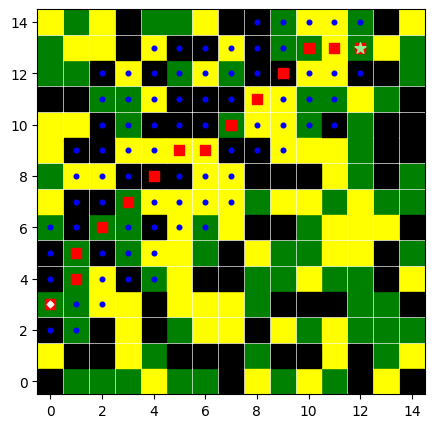

           D4 A* Manhattan search: 21.0 path cost, 90 states reached


In [19]:
# This code will not work until you have implemented appropriately the LandgridProblem class 
# These tests must pass!

#Landgrid 1 examples (5x5)
d1 = LandgridProblem(initial = (3,1), goal=(1,4), land_grid = land_grid1, heuristic='straight')

(bfs_d1, reached, frontiers) = breadth_first_bfs(d1)
plot_grid_problem(d1, bfs_d1, reached, title='D1 BFS', show=True)

(ucs_d1, reached, frontiers) = uniform_cost_search(d1) 
plot_grid_problem(d1, ucs_d1, reached, title='D1 UCF', show=True)

(as_d1, reached, frontiers) = astar_search(d1)
plot_grid_problem(d1, as_d1, reached, title='D1 A* search', show=True)

(grs_d1, reached, frontiers) = greedy_bfs(d1)
plot_grid_problem(d1, grs_d1, reached, title='D1 Greedy', show=True)

#Landgrid 4 examples (10x10, random)
d4 = LandgridProblem(initial = (0,3), goal=(12,13), land_grid = land_grid4, heuristic='straight')

(bfs_d4, reached, frontiers) = breadth_first_bfs(d4)
plot_grid_problem(d4, bfs_d4, reached, title='D4 BFS', show=True)

(ucs_d4, reached, frontiers) = uniform_cost_search(d4)
plot_grid_problem(d4, ucs_d4, reached, title='D4 UCF', show=True)

(as_d4, reached, frontiers) = astar_search(d4)
plot_grid_problem(d4, as_d4, reached, title='D4 A*', show=True)

(grs_d4, reached, frontiers) = greedy_bfs(d4)
plot_grid_problem(d4, grs_d4, reached, title='D4 Greedy', show=True)


# Heuristic switch examples
d4_h1 = LandgridProblem(initial = (0,3), goal=(12,13), land_grid = land_grid4, heuristic='straight')
(bfs_d4_h1, reached, frontiers) = astar_search(d4_h1)
plot_grid_problem(d4_h1, bfs_d4_h1, reached, title='D4 A* Straight', show=True)

d4_h2 = LandgridProblem(initial = (0,3), goal=(12,13), land_grid = land_grid4, heuristic='manhattan')
(bfs_d4_h2, reached, frontiers) = astar_search(d4_h2)
plot_grid_problem(d4_h2, bfs_d4_h2, reached, title='D4 A* Manhattan', show=True)

# QUESTION 6 CSP (Expected) - 4 points

Let's look at a simple basic implementation of recursive backtracking search for solving CSP problems. 

In [110]:
def isComplete(assignment):
    return None not in (assignment.values())

def select_unassigned_variable(variables, assignment):
    for var in variables:
        if assignment[var] is None:
            return var

def is_consistent(assignment, constraints):
    for constraint_violated in constraints:
        if constraint_violated(assignment):
          return False
    return True

def init_assignment(csp):
    assignment = {}
    for var in csp["VARIABLES"]:
        assignment[var] = None
    return assignment

def add_constraint(csp, constraint): 
    csp['CONSTRAINTS'].append(constraint)
    
def recursive_backtracking(assignment, csp):
    if isComplete(assignment):
        return assignment
    var = select_unassigned_variable(csp["VARIABLES"], assignment)
    for value in csp["DOMAINS"]:
        assignment[var] = value
        if is_consistent(assignment, csp["CONSTRAINTS"]):
            result = recursive_backtracking(assignment, csp)
            if result != "FAILURE":
                return result
        assignment[var] = None
    return "FAILURE"


def binary_constraint(var_pair, violations):
    (v1,v2) = var_pair
    return lambda asmt: (asmt[v1], asmt[v2]) in violations


We can use this implementation to solve the Australia map colouring problem. Before working on this question make sure you understand how the code works. *Looking at how csp_australia is defined and how binary constraints are defined as violations below can be useful in tracing how the code above works using this information.*

1. Add a unary constraint function. Similarly to binary constraint, it should return a function that takes as input an assignment and returns true if the assignment violates the constraint.
2. Show how this new unary constraint can be used to enforce that WA is blue
3. Now in addition to (2), use this new unary constraint to enforce that T is blue in the resulting solution.
4. Now in addition to (3), use this new unary constraint to enforce that NT is also blue in the resulting solution. See below for expected output.

In [111]:
csp_australia = {"VARIABLES": ["WA", "NT", "Q", "NSW", "V", "SA", "T"],
        "DOMAINS": ["red", "green", "blue"],
        "CONSTRAINTS": []}

violations = {('red','red'), ('green','green'), ('blue','blue')}

for (v1,v2) in [('WA', 'NT'), ('WA', 'SA'), 
                ('NT', 'SA'), ('NT', 'Q'), 
                ('SA', 'Q'), ('SA', 'NSW'), 
                ('SA', 'V'),('Q', 'NSW'), 
                ('V', 'T')]: 
    add_constraint(csp_australia, binary_constraint((v1,v2), violations))


In [112]:
# Q6 ANSWER GOES HERE
# HINTS:
# 0) define a unary constraint, see binary constrain above
# Repeat
# 1) add constraint to CSP
# 2) recursive backtracking on an initial assignment
# 3) print

def unary_constraint(var, unary_violations):
    return lambda asmt: asmt[var] in unary_violations

unary_violations = {("red"), ("green")}
add_constraint(csp_australia, unary_constraint("WA", unary_violations))

print("NOTE here the solution should have WA as blue")
print(f"Result {recursive_backtracking(init_assignment(csp_australia), csp_australia)}")

add_constraint(csp_australia, unary_constraint("T", unary_violations))

print("NOTE here the solution should have WA as blue and T as blue")
print(f"Result {recursive_backtracking(init_assignment(csp_australia), csp_australia)}")

add_constraint(csp_australia, unary_constraint("NT", unary_violations))

print("NOTE this is impossible, so failure!")
print(f"Result {recursive_backtracking(init_assignment(csp_australia), csp_australia)}")

# Expected output
# NOTE here the solution should have WA as blue
# Result {'WA': 'blue', 'NT': 'red', 'Q': 'blue', 'NSW': 'red', 'V': 'red', 'SA': 'green', 'T': 'green'}
# NOTE here the solution should have WA as blue and T as blue
# Result {'WA': 'blue', 'NT': 'red', 'Q': 'blue', 'NSW': 'red', 'V': 'red', 'SA': 'green', 'T': 'blue'}
# NOTE this is impossible, so failure!
# Result FAILURE

NOTE here the solution should have WA as blue
Result {'WA': 'blue', 'NT': 'red', 'Q': 'blue', 'NSW': 'red', 'V': 'red', 'SA': 'green', 'T': 'green'}
NOTE here the solution should have WA as blue and T as blue
Result {'WA': 'blue', 'NT': 'red', 'Q': 'blue', 'NSW': 'red', 'V': 'red', 'SA': 'green', 'T': 'blue'}
NOTE this is impossible, so failure!
Result FAILURE


# QUESTION 7 CSP (Advanced) - 10 points

Type inference is used in programming languages to 
infer the type of variables without explicitly stating it. 
Some examples: 
* x = 1  (we can infer x is an integer because 1 is an integer) 
* y = 1.0 (we can infer y is a float because 1.0 is a float) 
* z = x + y (we can infer z is a float because adding a float 
and an integer results in a float)

Constraint satisfaction problem solvers can be used to perform 
type inference. The variables of the programming languages become the variables of the CSP problem, and the domain of each variable is the types it can have. Constraints are created from the expressions analyzed in order to enforce that the assignment of variables to types is correct. Let's consider a simple example: 

* int I 
* float F 
* X = I 
* Y = X + F 
* Z = X + Y
* W = X + I 

We assume that when two variables are connected using assignment then they are the same type. So X is an integer because I has been declared an integer. The type of the result of adding two integers is an integer, the result of adding two floats is a float but the result of adding an integer and a float has type float. So we know that X is an integer and we add F which is a float therefore Y is a float and similarly Z is also a float.  W is an integer because X and I are integers. 

Notice that we did not declare the types of X, Y, and Z but were able to infer them using the semantics of the equality sign and addition. 

1. Your task for this question is to express this code as a CSP problem and solve it.
2. The result of the CSP will be the inferred types.
3. Each variable (I,F,X,Y,Z,W) will take values from the domain (int, float).
4. Unary constraints can be used for the type declaration and a binary constraint can be used for the assignment expression.
5. You will need to introduce a ternary_constraint method to express the sum expressions. 

In [114]:
# Q7 ANSWER GOES HERE

def ternary_constraint(var_trio, ternary_violations):
    (v1, v2, v3) = var_trio
    return lambda asmt: (asmt[v1], asmt[v2], asmt[v3]) in ternary_violations

csp1 = {"VARIABLES": ["I", "F", "X", "Y", "Z", "W"],
        "DOMAINS": ["int", "float"],
        "CONSTRAINTS": []}

unary_violations_I = {"float"}
unary_violations_F = {"int"}
binary_violations = {("int", "float"), ("float", "int")}
ternary_violations = {("int", "float", "int"), ("int", "int", "float"), ("float", "float", "int")}

add_constraint(csp1, unary_constraint("I", unary_violations_I))
add_constraint(csp1, unary_constraint("F", unary_violations_F))

var_pair = ("I", "X")
add_constraint(csp1, binary_constraint(var_pair, binary_violations))

var_trio = ("X", "F", "Y")
add_constraint(csp1, ternary_constraint(var_trio, ternary_violations))

var_trio = ("X", "Y", "Z")
add_constraint(csp1, ternary_constraint(var_trio, ternary_violations))

var_trio = ("X", "I", "W")
add_constraint(csp1, ternary_constraint(var_trio, ternary_violations))


result = recursive_backtracking(init_assignment(csp1), csp1)
print('Result', result)
# Result {'I': 'int', 'F': 'float', 'X': 'int', 'Y': 'float', 'Z': 'float', 'W': 'int'}



Result {'I': 'int', 'F': 'float', 'X': 'int', 'Y': 'float', 'Z': 'float', 'W': 'int'}
